In [1]:
# HACK: update sys.path for importing from parent directory
import os, sys
p = os.path.abspath('..')
print(p)
print(sys.path)
sys.path.insert(1, p)
print(sys.path)

/home/user/kew/INSTALLS/fudge
['/home/user/kew/INSTALLS/fudge/analysis', '/home/user/kew/anaconda3/envs/fudge_s3it/lib/python38.zip', '/home/user/kew/anaconda3/envs/fudge_s3it/lib/python3.8', '/home/user/kew/anaconda3/envs/fudge_s3it/lib/python3.8/lib-dynload', '', '/home/user/kew/anaconda3/envs/fudge_s3it/lib/python3.8/site-packages', '/home/user/kew/INSTALLS/fudge/transformers/src', '/home/user/kew/INSTALLS/easse']
['/home/user/kew/INSTALLS/fudge/analysis', '/home/user/kew/INSTALLS/fudge', '/home/user/kew/anaconda3/envs/fudge_s3it/lib/python38.zip', '/home/user/kew/anaconda3/envs/fudge_s3it/lib/python3.8', '/home/user/kew/anaconda3/envs/fudge_s3it/lib/python3.8/lib-dynload', '', '/home/user/kew/anaconda3/envs/fudge_s3it/lib/python3.8/site-packages', '/home/user/kew/INSTALLS/fudge/transformers/src', '/home/user/kew/INSTALLS/easse']


In [2]:
from types import SimpleNamespace
import numpy as np
import torch
from transformers import AutoTokenizer

from model import Model
from data import Dataset, collate
from util import pad_mask
from sklearn.metrics import roc_curve, roc_auc_score


In [3]:
args = {
        'data_dir': '/srv/scratch6/kew/ats/data/en/newsela_article_corpus_2016-01-29/article_sents/',
        'model_path_or_name': '/srv/scratch6/kew/ats/fudge/generators/bart_large_paraNMT_filt_fr',
#         'save_dir': '/srv/scratch6/kew/ats/fudge/discriminators/newsela4_bart_glove_bkup',
#         'ckpt': '/srv/scratch6/kew/ats/fudge/discriminators/newsela4_bart_glove_bkup/model_best.pth.tar',
        'save_dir': '/srv/scratch6/kew/ats/fudge/discriminators/wiki100M_bart_glove',
        'ckpt': '/srv/scratch6/kew/ats/fudge/discriminators/wiki100M_bart_glove/model_best.pth.tar',
        'device': 'cpu',
        'task': 'simplify',
        'evaluate': True,
        'seed': 1,
        'batch_size': 2,
        }

args = SimpleNamespace(**args)

# print(args)
# print(hasattr(args, 'dataset_info')) #.has_attribute(''))

In [4]:
dataset = Dataset(args)

loading data
loaded pre-compiled data splits from /srv/scratch6/kew/ats/fudge/discriminators/wiki100M_bart_glove/dataset_splts.pkl
Found exisiting dataset info - loading from file /srv/scratch6/kew/ats/fudge/discriminators/wiki100M_bart_glove/dataset_info
Done loading data!
Dataset balance:
complex / simple instances in train of size 1000005: 499996 / 500009
complex / simple instances in val of size 5016: 2503 / 2513
complex / simple instances in test of size 5011: 2507 / 2504


In [5]:
tokenizer = AutoTokenizer.from_pretrained(args.model_path_or_name)

In [6]:
checkpoint = torch.load(args.ckpt, map_location=args.device)
best_val_metric = checkpoint['best_metric']
model_args = checkpoint['args']
print(best_val_metric)
print(model_args)

tensor(0.4203)
Namespace(batch_size=128, ckpt=None, data_dir='/srv/scratch6/kew/ats/data/en/wiki_dumps', dataset_info=None, debug=False, device='cuda', epoch_max_len=500000, epochs=12, evaluate=False, glove='glove-wiki-gigaword-300', lr=0.0001, model_path_or_name='/srv/scratch6/kew/ats/fudge/generators/bart_large_paraNMT_filt_fr', num_workers=12, rhyme_info=None, save_dir='/srv/scratch6/kew/ats/fudge/discriminators/wiki100M_bart_glove', seed=1, task='simplify', tgt_level=4, train_print_freq=1000000, validation_freq=1, wandb='simple_fudge')


In [7]:
model = Model(
    model_args, 
    tokenizer.pad_token_id, 
    tokenizer.vocab_size,
    None
    ) # no need to get the glove embeddings when reloading since they're saved in model ckpt anyway

model.load_state_dict(checkpoint['state_dict'])
model = model.to(args.device)
model.eval()
# optimizer = torch.optim.Adam(model.parameters(), lr=model_args.lr)
# optimizer.load_state_dict(checkpoint['optimizer'])
# data_start_index = checkpoint['data_start_index']
# print("=> loaded checkpoint '{}' (epoch {})"
#     .format(args.ckpt, checkpoint['epoch']))


Model(
  (bart_embed): Embedding(50265, 300, padding_idx=1)
  (rnn): LSTM(300, 512, num_layers=3, dropout=0.1)
  (out_linear): Linear(in_features=512, out_features=1, bias=True)
)

In [8]:
loader = dataset.loader('val', num_workers=0)
print(loader)

In [9]:
print(dir(tokenizer))

['SPECIAL_TOKENS_ATTRIBUTES', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_add_tokens', '_additional_special_tokens', '_batch_encode_plus', '_bos_token', '_build_conversation_input_ids', '_cls_token', '_convert_encoding', '_convert_id_to_token', '_convert_token_to_id_with_added_voc', '_create_or_get_repo', '_decode', '_decode_use_source_tokenizer', '_encode_plus', '_eos_token', '_eventual_warn_about_too_long_sequence', '_from_pretrained', '_get_padding_truncation_strategies', '_get_repo_url_from_name', '_mask_token', '_pad', '_pad_token', '_pad_token_type_id', '_processor_class', '_push_to_hub', '_save_pretrained', '_sep_token', '_set_processor_clas

In [41]:
criterion = torch.nn.BCEWithLogitsLoss().to(args.device)

    
def prepare(sent, label):
    orig_sent = sent.split()
#     print(tokenizer.encode(sent, add_special_tokens=False, return_token_type_ids=False))
    toks = tokenizer.encode(sent, add_special_tokens=False, return_tensors="pt")[0]
    print('*** input ***')
    print(tokenizer.convert_ids_to_tokens(toks))
    word_log_prob = 0
    future_word = 0
    future_word_num_syllables, rhyme_group_index, syllables_to_go = -1, -1, -1 # not required for simplify

    pad_id = tokenizer.pad_token_id

    example = (
        toks, 
        len(toks), 
        future_word, 
        word_log_prob, 
        pad_id, 
        label, 
        syllables_to_go, 
        future_word_num_syllables, 
        rhyme_group_index)

    batch = collate([example])
    print(batch)
    print()
    
    return batch
    
def score(batch):
#     print('*** preds ***')
    scores = model(batch[0], lengths=batch[1])
    print('MODEL SCORES:', scores.tolist())
    
    expanded_labels = batch[5].unsqueeze(1).expand(-1, scores.shape[1]) # batch x seq
    print('TRUE LABELS:', expanded_labels.tolist())
    length_mask = pad_mask(batch[1]).permute(1, 0) # batch x seq
    loss = criterion(scores.flatten()[length_mask.flatten()==1], expanded_labels.flatten().float()[length_mask.flatten()==1])
    print('MODEL LOSS:', loss.tolist())
    acc = ((scores.flatten()[length_mask.flatten()==1] > 0.0) == expanded_labels.flatten().float()[length_mask.flatten()==1]).float().mean()
    print('PRED ACC (0.0 Threshold):', acc.tolist())

    #####
    neg_scores = -torch.ones_like(scores)
    print('NEG PRED LOSS:', criterion(neg_scores.flatten()[length_mask.flatten()==1], expanded_labels.flatten().float()[length_mask.flatten()==1]).tolist())
    print('NEG PRED ACC:', ((neg_scores.flatten()[length_mask.flatten()==1] > 0.0) == expanded_labels.flatten().float()[length_mask.flatten()==1]).float().mean().tolist())

    pos_scores = torch.ones_like(scores)
    print('POS PRED LOSS:', criterion(pos_scores.flatten()[length_mask.flatten()==1], expanded_labels.flatten().float()[length_mask.flatten()==1]).tolist())
    print('POS PRED LOSS:', ((pos_scores.flatten()[length_mask.flatten()==1] > 0.0) == expanded_labels.flatten().float()[length_mask.flatten()==1]).float().mean().tolist())
    print()
    
    return scores.flatten()[length_mask.flatten()==1].detach().numpy(), expanded_labels.flatten().float()[length_mask.flatten()==1].detach().numpy()


examples = [
    ("They do not talk about their experiences.", 1),
    ("Their experiences are rendered invisible in many ways.", 0),
    ("They do not discuss their experiences for they bequeath these unto others", 1)
]

y_hats, y_labels = [], []

for ex in examples:
    y_hat, y_label = score(prepare(*ex))
    print(len(y_hat))
    y_hats.append(y_hat)
    y_labels.append(y_label)

y_hats = np.concatenate(y_hats, 0)
y_labels = np.concatenate(y_labels, 0)

print(type(y_hats), y_hats.shape)
    
    

*** input ***
['They', 'Ġdo', 'Ġnot', 'Ġtalk', 'Ġabout', 'Ġtheir', 'Ġexperiences', '.']
(tensor([[1213,  109,   45, 1067,   59,   49, 3734,    4]]), tensor([8]), tensor([[0]]), tensor([0.]), tensor([[1]]), tensor([1]), tensor([-1]), tensor([-1]), tensor([-1]))

MODEL SCORES: [[1.0252163410186768, 2.311413526535034, 2.0452494621276855, 2.6395671367645264, 3.2879037857055664, 3.634249687194824, 2.984743595123291, 3.543301582336426]]
TRUE LABELS: [[1, 1, 1, 1, 1, 1, 1, 1]]
MODEL LOSS: 0.091523677110672
PRED ACC (0.0 Threshold): 1.0
NEG PRED LOSS: 1.31326162815094
NEG PRED ACC: 0.0
POS PRED LOSS: 0.31326165795326233
POS PRED LOSS: 1.0

8
*** input ***
['Their', 'Ġexperiences', 'Ġare', 'Ġrendered', 'Ġinvisible', 'Ġin', 'Ġmany', 'Ġways', '.']
(tensor([[16837,  3734,    32, 18728, 20731,    11,   171,  1319,     4]]), tensor([9]), tensor([[0]]), tensor([0.]), tensor([[1]]), tensor([0]), tensor([-1]), tensor([-1]), tensor([-1]))

MODEL SCORES: [[0.44716396927833557, -0.4290010631084442, 0.6218

In [42]:
# https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/
# roc curve for models

print('PREDS:', y_hats)
fpr1, tpr1, thresh1 = roc_curve(y_labels, y_hats, pos_label=1)
print('FPR:', fpr1, 'TPR:', tpr1, 'THRESHOLDS:', thresh1)
# fpr2, tpr2, thresh2 = roc_curve(y_label, y_hat, pos_label=1)

# roc curve for tpr = fpr 
# random_probs = [0 for i in range(len(y_labels))]
random_probs = np.random.permutation(y_hats)
print('RANDOM PREDS:', random_probs)
p_fpr, p_tpr, _ = roc_curve(y_labels, random_probs, pos_label=0)
print(p_fpr, p_tpr)

# auc scores
auc_score1 = roc_auc_score(y_labels, y_hats)
auc_score2 = roc_auc_score(y_labels, random_probs)
print(auc_score1, auc_score2)

PREDS: [ 1.0252163   2.3114135   2.0452495   2.6395671   3.2879038   3.6342497
  2.9847436   3.5433016   0.44716397 -0.42900106  0.6218838  -0.29087594
 -0.28846794 -0.2915672  -0.33297947 -0.49348518  0.24713552  1.0252163
  2.3114135   2.0452495   1.4554809   2.1266313   1.3313273   1.5222127
  2.1495895   1.807233    1.6221952   1.6005733   1.3312769   1.0093769
  0.7732773 ]
FPR: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] TPR: [0.         0.04545455 0.22727273 0.31818182 0.40909091 0.5
 0.81818182 0.90909091 1.         1.        ] THRESHOLDS: [ 4.6342497   3.6342497   2.6395671   2.3114135   2.1266313   2.0452495
  1.3312769   1.0252163   0.7732773  -0.49348518]
RANDOM PREDS: [-0.2915672   1.0252163   2.3114135   1.3313273   2.0452495  -0.29087594
  3.5433016  -0.33297947  1.5222127  -0.49348518  0.24713552  0.6218838
  2.1266313  -0.42900106  1.0093769   2.1495895   3.2879038   0.7732773
  2.6395671  -0.28846794  2.9847436   1.4554809   1.0252163   1.807233
  2.3114135   1.6005733   2.045249

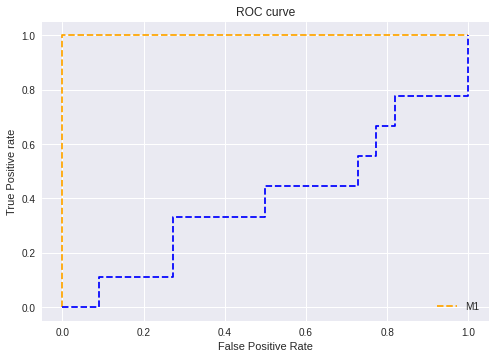

In [43]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='M1')
# plt.plot(fpr2, tpr2, linestyle='--',color='green', label='KNN')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
# plt.savefig('ROC',dpi=300)
# plt.show();